In [1]:
# Loading required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
import xlrd
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import OneHotEncoder

In [3]:
# Read data files into data frames 
customerdata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/QVI_purchase_behaviour.csv')
transactiondata = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Dataset/QVI_transaction_data.xlsx')

#Exploratory Data Analysis
First, we want to examine the data and make sure that it is in a usable form for our analysis.

In [4]:
# Examining the transaction data - view a summary of the table
trans_df  = transactiondata.copy() # Keep a copy for a quick reset 
trans_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


Then we want to ensure that we are only examining chip purchases.

In [8]:
# View all unique entries in the product name column
trans_df['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

While it looks like we have chips, we want to check that the products are only chips by counting the word frequencies in the product names. To make this process clearer, we can remove the digits and symbols from the names

In [9]:
# Remove digits from the product names
prod_name = trans_df['PROD_NAME'].str.replace(r'[0-9]+[gG]','');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [10]:
# Remove & characters from the product names and replace with a space to separate flavours
prod_name = prod_name.str.replace(r'&',' ');

In [12]:
prod_name

0           Natural Chip        Compny SeaSalt
1                         CCs Nacho Cheese    
2           Smiths Crinkle Cut  Chips Chicken 
3           Smiths Chip Thinly  S/Cream Onion 
4         Kettle Tortilla ChpsHny Jlpno Chili 
                          ...                 
264831     Kettle Sweet Chilli And Sour Cream 
264832               Tostitos Splash Of  Lime 
264833                    Doritos Mexicana    
264834     Doritos Corn Chip Mexican Jalapeno 
264835               Tostitos Splash Of  Lime 
Name: PROD_NAME, Length: 264836, dtype: object

In [13]:
# Count the frequencies of words in product names and display counts in descending order
word_counts = pd.Series(' '.join(prod_name).split()).value_counts()
with pd.option_context('display.max_rows', None): # show all rows
  display(word_counts)

Chips              49770
Kettle             41288
Smiths             28860
Salt               27976
Cheese             27890
Pringles           25102
Doritos            24962
Crinkle            23960
Corn               22063
Original           21560
Cut                20754
Chip               18645
Chicken            18577
Salsa              18094
Chilli             15390
Sea                14145
Thins              14075
Sour               13882
Crisps             12607
Vinegar            12402
RRD                11894
Sweet              11060
Infuzions          11057
Supreme            10963
Chives             10951
Cream              10723
WW                 10320
Popd                9693
Cobs                9693
Tortilla            9580
Tostitos            9471
Twisties            9454
BBQ                 9434
Sensations          9429
Lime                9347
Paso                9324
Dip                 9324
Old                 9324
El                  9324
Tomato              7669


Some entries in our data are salsas; we want to remove these.

In [14]:
# Remove salsas from the dataset
trans_df = trans_df[trans_df['PROD_NAME'].str.contains(r"[Ss]alsa") == False]
trans_df.shape # check for a reduction in no of rows

(246742, 8)

Now we can create summaries of the data (eg min, max, mean) to see if there are any obvious outliers in the data and if there are any nulls in any of the columns.

In [15]:
# Create summaries of the transaction data
trans_df.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
std,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000


In [16]:
# Check if there are any nans in the dataset 
trans_df.isnull().values.any()

False

From the summary, there is at least one transaction with 200 packets. Let's investigate this purchase further.

In [17]:
# Filter the entries that have 200 packets. 
trans_df.loc[trans_df['PROD_QTY'] == 200.0]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


The same customer has made these transactions. They could have been for commercial purposes so we can check to see if they made any other purchases.

In [18]:
# Filter the entires by the customer
trans_df.loc[trans_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


It looks like this is the only purchase they have made so we will remove these transactions from the dataset.

In [19]:
# Remove the transactions
trans_df = trans_df[trans_df['LYLTY_CARD_NBR'] != 226000]
trans_df.shape # check for a reduction of 2 rows (i.e. 246740 rows)

(246740, 8)

In [20]:
# Recheck the data summary 
trans_df.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
std,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897
min,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000


In [21]:
# Count transactions by date to see if there are any missing days 
count = trans_df.groupby(trans_df['DATE'].dt.date).size().reset_index(name = 'COUNT')
count.shape

(364, 2)

In [22]:
count

,DATE,COUNT
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660
...,...,...
359,2019-06-26,657
360,2019-06-27,669
361,2019-06-28,673
362,2019-06-29,703


In [23]:
# There is one day of data missing. First check the range of dates by sorting in time order. 
trans_df.sort_values(by='DATE')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
9161,2018-07-01,88,88140,86914,25,Pringles SourCream Onion 134g,2,7.4
155442,2018-07-01,60,60276,57330,3,Kettle Sensations Camembert & Fig 150g,2,9.2
181349,2018-07-01,199,199014,197623,104,Infuzions Thai SweetChili PotatoMix 110g,2,7.6
229948,2018-07-01,35,35052,31630,11,RRD Pc Sea Salt 165g,1,3.0
104647,2018-07-01,72,72104,71038,20,Doritos Cheese Supreme 330g,2,11.4
...,...,...,...,...,...,...,...,...
10254,2019-06-30,112,112141,114611,98,NCC Sour Cream & Garden Chives 175g,2,6.0
113220,2019-06-30,207,207155,205513,99,Pringles Sthrn FriedChicken 134g,2,7.4
229182,2019-06-30,10,10140,9882,12,Natural Chip Co Tmato Hrb&Spce 175g,2,6.0
229015,2019-06-30,6,6258,6047,29,French Fries Potato Chips 175g,1,3.0


We can see that the dates range from 1 Jul 2018 to 30 Jun 2019. Now we want to check through the year of dates to see which day the data is missing.

In [24]:
# Generate a list of dates with transactions in ascending order 
date_counts = trans_df.groupby('DATE').size()

# Then compare to a full list of dates within the same range to find differences between them 
pd.date_range(start = '2018-07-01', end = '2019-06-30' ).difference(date_counts.index)

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

The missing date is Christmas day, a public holiday, so it is expected that there are no sales on this day. Now we move onto creating other features such as the pack size, and checking this for any outliers.

In [25]:
# Add a new column to data with packet sizes and extract sizes from product name column
trans_df.insert(8, "PACK_SIZE", trans_df['PROD_NAME'].str.extract('(\d+)').astype(float), True)

# Sort by packet sizes to check for outliers 
trans_df.sort_values(by='PACK_SIZE')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
40783,2018-09-25,97,97067,96696,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
42461,2019-05-05,110,110030,111890,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
176183,2018-12-30,82,82183,81660,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
227309,2018-12-03,236,236091,239098,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
42418,2018-11-05,109,109217,111470,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
...,...,...,...,...,...,...,...,...,...
192034,2019-03-12,100,100121,99145,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
255797,2019-01-19,235,235098,238018,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
233814,2019-01-24,151,151102,149810,4,Dorito Corn Chp Supreme 380g,1,6.5,380.0
131573,2018-07-09,213,213087,212416,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0


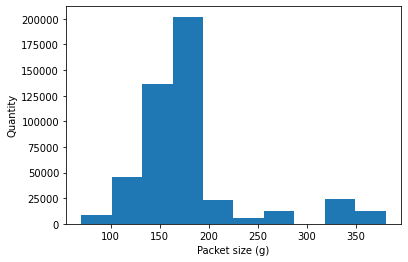

In [28]:
# Minimum packet size is 70g while max is 380g - this is reasonable. 
# Plot a histogram to visualise distribution of pack sizes. 
plt.hist(trans_df['PACK_SIZE'], weights=trans_df['PROD_QTY']);
plt.xlabel('Packet size (g)');
plt.ylabel('Quantity');

Now that the pack size looks reasonable, we can create the brand names using the first word of each product name.

In [29]:
# Add a column to extract the first word of each product name to. 
trans_df.insert(9, "BRAND_NAME",trans_df['PROD_NAME'].str.split().str.get(0), True)
trans_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175.0,Kettle
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175.0,Tostitos
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170.0,Doritos
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,Doritos


In [30]:
# Then print all unique entries to check the brand names created
trans_df["BRAND_NAME"].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [31]:
# Create a function to identify the string replacements needed.
def replace_brandname(line):
    name = line['BRAND_NAME']
    if name == "Infzns":
        return "Infuzions"
    elif name == "Red":
        return "Red Rock Deli"
    elif name == "RRD":
        return "Red Rock Deli"
    elif name == "Grain":
        return "Grain Waves"
    elif name == "GrnWves":
        return "Grain Waves"
    elif name == "Snbts":
        return "Sunbites"
    elif name == "Natural":
        return "Natural Chip Co"
    elif name == "NCC":
        return "Natural Chip Co"
    elif name == "WW":
        return "Woolworths"
    elif name == "Smith":
        return "Smiths"
    elif name == "Dorito":
        return "Doritos"
    else:
        return name 

In [32]:
trans_df["BRAND_NAME"].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [33]:
# Then apply the function to clean the brand names
trans_df["BRAND_NAME"] = trans_df.apply(lambda line: replace_brandname(line), axis=1)

In [34]:
# Check that there are no duplicate brands 
trans_df["BRAND_NAME"].unique()

array(['Natural Chip Co', 'CCs', 'Smiths', 'Kettle', 'Grain Waves',
       'Doritos', 'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

The brand names seme reasonable, without duplicates.

Now we want to examine the customer data. We can generate summaries and check the categories in this dataset.

In [35]:
# Now examine customer data
cust_df = customerdata.copy()
cust_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [36]:
# Rename "PREMIUM_CUSTOMER" to "MEMBER_TYPE" for easier identification of the column data
cust_df = cust_df.rename(columns={'PREMIUM_CUSTOMER': 'MEMBER_TYPE'})

In [37]:
# Check the summary of the customer data
cust_df.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [38]:
# Check the entries in the member type and lifestage columns
cust_df["MEMBER_TYPE"].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

In [39]:
cust_df["LIFESTAGE"].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

Now that the customer dataset looks fine, we want to add this information to the transactions dataset.

In [41]:
# Join the customer and transaction datasets, and sort transactons by date 
full_df = trans_df.set_index('LYLTY_CARD_NBR').join(cust_df.set_index('LYLTY_CARD_NBR'))
full_df = full_df.reset_index()
full_df = full_df.sort_values(by='DATE').reset_index(drop=True)
full_df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,LIFESTAGE,MEMBER_TYPE
0,21037,2018-07-01,21,17576,62,Pringles Mystery Flavour 134g,2,7.4,134.0,Pringles,RETIREES,Mainstream
1,25040,2018-07-01,25,21704,87,Infuzions BBQ Rib Prawn Crackers 110g,2,7.6,110.0,Infuzions,OLDER FAMILIES,Budget
2,59236,2018-07-01,59,55555,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,Doritos,OLDER SINGLES/COUPLES,Budget
3,271083,2018-07-01,271,268688,97,RRD Salt & Vinegar 165g,2,6.0,165.0,Red Rock Deli,YOUNG FAMILIES,Budget
4,65015,2018-07-01,65,61737,17,Kettle Sensations BBQ&Maple 150g,2,9.2,150.0,Kettle,YOUNG FAMILIES,Premium
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,48160,2019-06-30,48,44051,11,RRD Pc Sea Salt 165g,2,6.0,165.0,Red Rock Deli,RETIREES,Mainstream
246736,175371,2019-06-30,175,176890,40,Thins Chips Seasonedchicken 175g,2,6.6,175.0,Thins,OLDER SINGLES/COUPLES,Budget
246737,203312,2019-06-30,203,203610,68,Pringles Chicken Salt Crips 134g,2,7.4,134.0,Pringles,MIDAGE SINGLES/COUPLES,Mainstream
246738,222003,2019-06-30,222,221524,17,Kettle Sensations BBQ&Maple 150g,2,9.2,150.0,Kettle,RETIREES,Mainstream


In [42]:
# Check for nulls in the full dataset
full_df.isnull().values.any()

False

In [43]:
# looks like all the data is reasonable so export to CSV
full_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/QVI_fulldata.csv')

#Data analysis on customer segments
Now that the data has been cleaned, we want to look for interesting insights in the chip market to help recommend a business strategy.

To do so, some metrics we want to consider are:

Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
How many customers are in each segment
How many chips are bought per customer by segment
What's the average chip price by customer segment
Some more information from the data team that we could ask for, to analyse with the chip information for more insight includes

The customer’s total spend over the period and total spend for each transaction to understand what proportion of their grocery spend is on chips.
Spending on other snacks, such as crackers and biscuits, to determine the preference and the purchase frequency of chips compared to other snacks
Proportion of customers in each customer segment overall to compare against the mix of customers who purchase chips
Firstly, we want to take a look at the split of the total sales by LIFESTAGE and MEMBER_TYPE.

In [46]:
# calculate total sales by lifestage and member type and generate a list  
total_sales_cust = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'], as_index = False)['TOT_SALES'].agg(['sum'])
total_sales_cust = total_sales_cust.rename(columns={'sum': 'sum_tot_sales'})
total_sales_cust.sort_values(by = "sum_tot_sales", ascending = False)
total_sales_cust

sum_tot_sales
LIFESTAGE              MEMBER_TYPE               
MIDAGE SINGLES/COUPLES Budget            33345.70
                       Mainstream        84734.25
                       Premium           54443.85
NEW FAMILIES           Budget            20607.45
                       Mainstream        15979.70
                       Premium           10760.80
OLDER FAMILIES         Budget           156863.75
                       Mainstream        96413.55
                       Premium           75242.60
OLDER SINGLES/COUPLES  Budget           127833.60
                       Mainstream       124648.50
                       Premium          123537.55
RETIREES               Budget           105916.30
                       Mainstream       145168.95
                       Premium           91296.65
YOUNG FAMILIES         Budget           129717.95
                       Mainstream        86338.25
                       Premium           78571.70
YOUNG SINGLES/COUPLES  Budget            57122.10
                       Mainstream       147582.20
                       Premium           39052.30

In [47]:
# Get the total sales 
total_sales = full_df['TOT_SALES'].agg(['sum'])['sum']
total_sales

1805177.7000000002

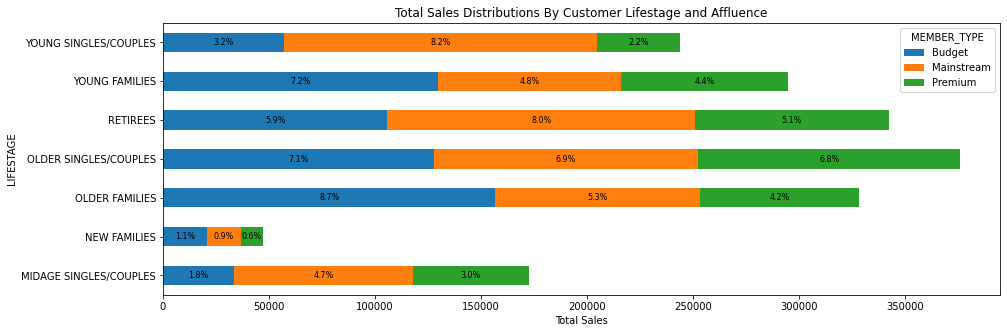

In [48]:
# Plot a breakdown of the total sales by lifestage and member type
total_sales_breakdown = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'], as_index = False)['TOT_SALES'].agg(['sum', 'mean']).unstack('MEMBER_TYPE').fillna(0)
ax = total_sales_breakdown['sum'].plot(kind='barh', stacked=True, figsize=(15, 5))

# Add percentages of the summed total sales as labels to each bar 
# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    label = width / total_sales * 100
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{(label):.1f}%' 
    
    # Set label positions
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)
        
ax.set_xlabel("Total Sales")
ax.set_title('Total Sales Distributions By Customer Lifestage and Affluence')
plt.show()

Here, we can see the most sales are from Older families - Budget, Young singles/couples - Mainstream and Retirees - Mainstream. We can see if this is because of the customer numbers in each segment.

In [49]:
# Check all rows are unique in customer information
len(cust_df['LYLTY_CARD_NBR'].unique()) == cust_df.shape[0]

True

True

In [51]:
# Check if all customers made chip purchases. 
len(cust_df['LYLTY_CARD_NBR'].unique()) == len(full_df['LYLTY_CARD_NBR'].unique())

False

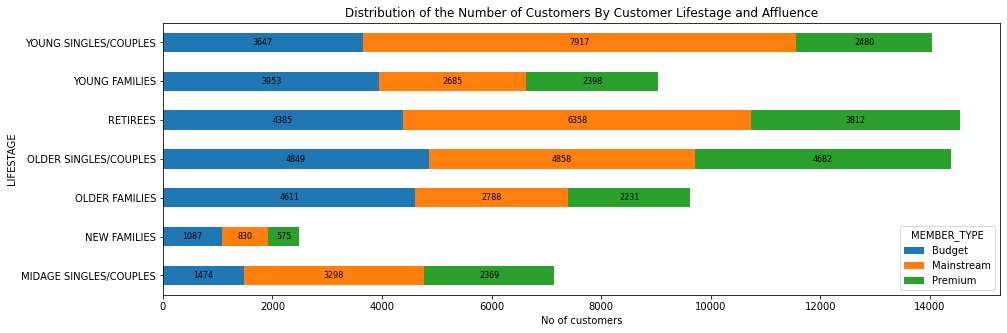

In [52]:
# Plot the numbers of customers in each segment by counting the unique LYLTY_CARD_NBR entries
sum_customers= full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['LYLTY_CARD_NBR'].agg('nunique').unstack('MEMBER_TYPE').fillna(0)
ax = sum_customers.plot(kind='barh', stacked=True, figsize=(15, 5))

# Add customer numbers as labels to each bar 
# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{(width):.0f}'
    
    # Set label positions
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)
        
ax.set_xlabel("No of customers")
ax.set_title('Distribution of the Number of Customers By Customer Lifestage and Affluence')
plt.show()

There are more Young singles/couples - mainstream and Retirees - mainstream who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Older families - budget segment.

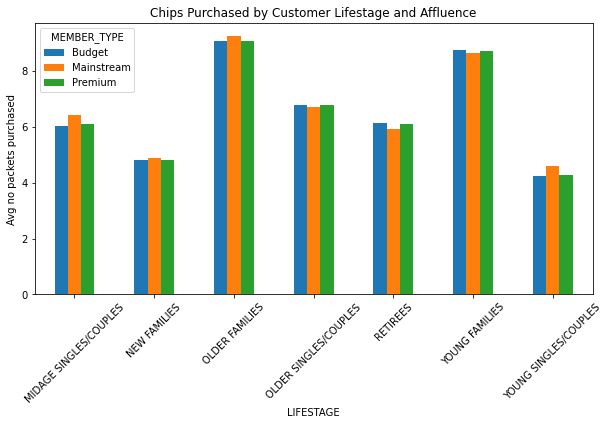

In [53]:
# Plot the average no of chip packets bought per customer by LIFESTAGE and MEMBER_TYPE.
no_packets_data = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['PROD_QTY'].sum()/full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['LYLTY_CARD_NBR'].nunique(0)
ax = no_packets_data.unstack('MEMBER_TYPE').fillna(0).plot.bar(stacked = False,figsize=(10, 5))
ax.set_ylabel("Avg no packets purchased")
ax.set_title('Chips Purchased by Customer Lifestage and Affluence')
plt.xticks(rotation=45)
plt.show()

Older families and young families in general buy more chips per customer. We can also investigate the average price per unit sold by LIFESTAGE and MEMBER_TYPE.

In [54]:
# Create a column for the unit price of chips purchased per transaction 
full_df['UNIT_PRICE'] = full_df['TOT_SALES']/full_df['PROD_QTY']

In [55]:
full_df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,LIFESTAGE,MEMBER_TYPE,UNIT_PRICE
0,21037,2018-07-01,21,17576,62,Pringles Mystery Flavour 134g,2,7.4,134.0,Pringles,RETIREES,Mainstream,3.7
1,25040,2018-07-01,25,21704,87,Infuzions BBQ Rib Prawn Crackers 110g,2,7.6,110.0,Infuzions,OLDER FAMILIES,Budget,3.8
2,59236,2018-07-01,59,55555,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,Doritos,OLDER SINGLES/COUPLES,Budget,3.9
3,271083,2018-07-01,271,268688,97,RRD Salt & Vinegar 165g,2,6.0,165.0,Red Rock Deli,YOUNG FAMILIES,Budget,3.0
4,65015,2018-07-01,65,61737,17,Kettle Sensations BBQ&Maple 150g,2,9.2,150.0,Kettle,YOUNG FAMILIES,Premium,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,48160,2019-06-30,48,44051,11,RRD Pc Sea Salt 165g,2,6.0,165.0,Red Rock Deli,RETIREES,Mainstream,3.0
246736,175371,2019-06-30,175,176890,40,Thins Chips Seasonedchicken 175g,2,6.6,175.0,Thins,OLDER SINGLES/COUPLES,Budget,3.3
246737,203312,2019-06-30,203,203610,68,Pringles Chicken Salt Crips 134g,2,7.4,134.0,Pringles,MIDAGE SINGLES/COUPLES,Mainstream,3.7
246738,222003,2019-06-30,222,221524,17,Kettle Sensations BBQ&Maple 150g,2,9.2,150.0,Kettle,RETIREES,Mainstream,4.6


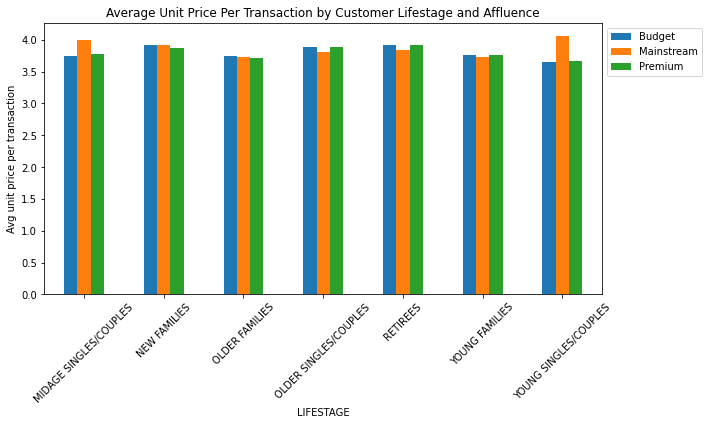

In [57]:
# Plot the distribution of the average unit price per transaction by LIFESTAGE and MEMBER_TYPE.
avg_priceperunit = full_df.groupby(['LIFESTAGE', 'MEMBER_TYPE'], as_index = False)['UNIT_PRICE'].agg(['mean']).unstack('MEMBER_TYPE').fillna(0)
ax = avg_priceperunit['mean'].plot.bar(stacked=False, figsize=(10, 5))
ax.set_ylabel("Avg unit price per transaction")
ax.set_title('Average Unit Price Per Transaction by Customer Lifestage and Affluence')
plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=45)
plt.show()

For young and midage singles/couples, the mainstream group are more willing to pay more for a packet of chips than their budget and premium counterpart. Given the total sales, as well as the number of customers buying chips, is higher in these groups compared to the non-mainstream groups, this suggests that chips may not be the choice of snack for these groups. Further information on shopping habits would be useful in this case.

As the difference in average price per unit isn’t large, we can check if this difference is statistically different, with a t-test.

In [58]:
# Check the difference in the average price unit between the mainstream and premium/budget groups for young/midage singles/couples
from scipy.stats import ttest_ind

# Identify the groups to test the hypthesis with 
mainstream = full_df["MEMBER_TYPE"] == "Mainstream"
young_midage = (full_df["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES") | (full_df["LIFESTAGE"] == "YOUNG SINGLES/COUPLES")
premium_budget = full_df["MEMBER_TYPE"] != "Mainstream"

group1 = full_df[mainstream & young_midage]["UNIT_PRICE"]
group2 = full_df[premium_budget & young_midage]["UNIT_PRICE"]

# Generate the t-test 
stat, pval = ttest_ind(group1.values, group2.values, equal_var=False)

print(pval, stat)

6.967354232991988e-306 37.6243885962296


The t-test results in a p-value of 6.97e-306, being close to 0, indicates that the unit price for mainstream, young and mid-age singles and couples ARE significantly higher than that of budget or premium, young and midage singles and couples.

# Deep dive into specific customer segments for insights

We have found quite a few interesting insights that we can dive deeper into. We might want to target customer segments that contribute the most to sales to retain them or further increase sales. Let's look at Mainstream - young singles/couples. For instance, let's find out if they tend to buy a particular brand of chips.

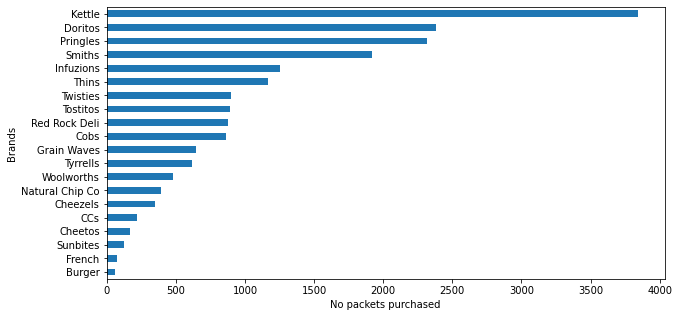

In [59]:
# Create a visual of what brands young singles/couples are purchasing the most for a general indication
young_mainstream = full_df.loc[full_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).plot.barh(figsize=(10, 5))
ax.set_xlabel("No packets purchased")
ax.set_ylabel("Brands")
plt.show()

In [60]:
temp = full_df.copy()
temp["group"] = temp["LIFESTAGE"] + ' - ' + temp['MEMBER_TYPE']

In [61]:
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["BRAND_NAME"])
groups_brands = groups.join(brands)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,OLDER SINGLES/COUPLES - Mainstream,OLDER SINGLES/COUPLES - Premium,RETIREES - Budget,RETIREES - Mainstream,RETIREES - Premium,YOUNG FAMILIES - Budget,YOUNG FAMILIES - Mainstream,YOUNG FAMILIES - Premium,YOUNG SINGLES/COUPLES - Budget,YOUNG SINGLES/COUPLES - Mainstream,YOUNG SINGLES/COUPLES - Premium,Burger,CCs,Cheetos,Cheezels,Cobs,Doritos,French,Grain Waves,Infuzions,Kettle,Natural Chip Co,Pringles,Red Rock Deli,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
246736,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
246737,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
246738,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [62]:
freq_groupsbrands = apriori(groups_brands, min_support=0.008, use_colnames=True)
rules = association_rules(freq_groupsbrands, metric="lift", min_threshold=0.5)
rules.sort_values('confidence', ascending = False, inplace = True)

In [63]:
set_temp = temp["group"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
41,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.079209,0.167334,0.015579,0.196684,1.175400,0.002325,1.036537
1,(MIDAGE SINGLES/COUPLES - Mainstream),(Kettle),0.044966,0.167334,0.008657,0.192519,1.150508,0.001132,1.031190
23,(RETIREES - Budget),(Kettle),0.057652,0.167334,0.010505,0.182214,1.088926,0.000858,1.018196
33,(RETIREES - Premium),(Kettle),0.049591,0.167334,0.008981,0.181105,1.082296,0.000683,1.016816
13,(OLDER SINGLES/COUPLES - Budget),(Kettle),0.069596,0.167334,0.012422,0.178488,1.066658,0.000776,1.013578
20,(OLDER SINGLES/COUPLES - Premium),(Kettle),0.067115,0.167334,0.011944,0.177959,1.063495,0.000713,1.012925
26,(RETIREES - Mainstream),(Kettle),0.080935,0.167334,0.013723,0.169554,1.013269,0.000180,1.002674
17,(OLDER SINGLES/COUPLES - Mainstream),(Kettle),0.069146,0.167334,0.011490,0.166168,0.993034,-0.000081,0.998602
35,(YOUNG FAMILIES - Budget),(Kettle),0.071991,0.167334,0.011117,0.154422,0.922837,-0.000930,0.984730
5,(OLDER FAMILIES - Budget),(Kettle),0.087193,0.167334,0.013455,0.154318,0.922216,-0.001135,0.984609


In [64]:
rules[rules['antecedents'] == {'YOUNG SINGLES/COUPLES - Mainstream'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
41,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.079209,0.167334,0.015579,0.196684,1.175400,0.002325,1.036537
38,(YOUNG SINGLES/COUPLES - Mainstream),(Doritos),0.079209,0.102229,0.009642,0.121725,1.190712,0.001544,1.022198
42,(YOUNG SINGLES/COUPLES - Mainstream),(Pringles),0.079209,0.101735,0.009382,0.118451,1.164310,0.001324,1.018962


From apriori analysis, we can see that for Mainstream - young singles/couples, Kettle is the brand of choice. This is also true for most other segments. We can use the affinity index to see if there are brands this segment prefers more than the other segments to target.

In [65]:
# find the target rating proportion
target_segment = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

In [66]:
# find the target rating proportion
target_segment = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

# find the other rating proportion
not_young_mainstream = full_df.loc[full_df['LIFESTAGE'] != "YOUNG SINGLES/COUPLES"]
not_young_mainstream = not_young_mainstream.loc[not_young_mainstream['MEMBER_TYPE'] != "Mainstream"]
other = not_young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

In [67]:
# join the two dataframes 
brand_proportions = target_segment.set_index('BRANDS').join(other.set_index('BRANDS'))
# full_df = trans_df.set_index('LYLTY_CARD_NBR').join(cust_df.set_index('LYLTY_CARD_NBR'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,BRANDS,target,other,affinity
8,Tyrrells,0.017088,0.013368,1.278270
13,Twisties,0.024845,0.019632,1.265496
18,Doritos,0.065673,0.052511,1.250646
12,Tostitos,0.024569,0.019944,1.231911
19,Kettle,0.106115,0.086574,1.225712
17,Pringles,0.063906,0.052477,1.217793
10,Cobs,0.023851,0.020004,1.192293
15,Infuzions,0.034507,0.029930,1.152890
9,Grain Waves,0.017833,0.016214,1.099878
14,Thins,0.032188,0.029771,1.081172


By using the affinity index, we can see that mainstream young singles/couples are 28% more likely to purcahse Tyrrells chips than the other segments. However, they are 50% less likely to purchase Burger Rings.

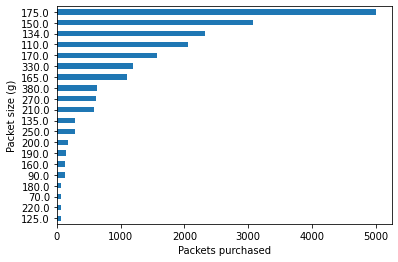

In [68]:
# Plot the distribution of the packet sizes for a general indication of what it most popular. 
young_mainstream = full_df.loc[full_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).plot.barh()
ax.set_ylabel("Packet size (g)")
ax.set_xlabel("Packets purchased")
plt.show()

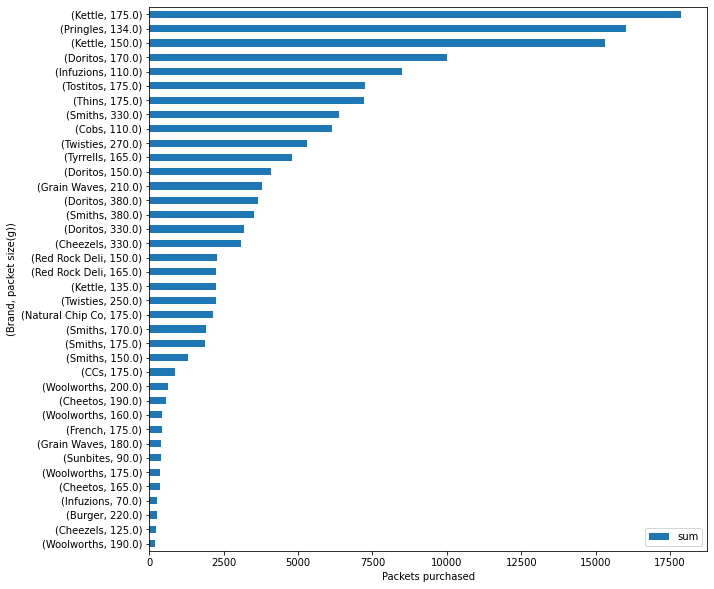

In [69]:
# Also want to check which brands correspond to what sized packets. 
brand_size = young_mainstream.groupby(['BRAND_NAME','PACK_SIZE'], as_index = False)['TOT_SALES'].agg(['sum'])
ax = brand_size.sort_values(by = 'sum').plot.barh(y = "sum", figsize=(10,10))
ax.set_ylabel("(Brand, packet size(g))")
ax.set_xlabel("Packets purchased")
plt.show()

In [70]:
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["PACK_SIZE"])
groups_brands = groups.join(brands)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,OLDER SINGLES/COUPLES - Mainstream,OLDER SINGLES/COUPLES - Premium,RETIREES - Budget,RETIREES - Mainstream,RETIREES - Premium,YOUNG FAMILIES - Budget,YOUNG FAMILIES - Mainstream,YOUNG FAMILIES - Premium,YOUNG SINGLES/COUPLES - Budget,YOUNG SINGLES/COUPLES - Mainstream,YOUNG SINGLES/COUPLES - Premium,70.0,90.0,110.0,125.0,134.0,135.0,150.0,160.0,165.0,170.0,175.0,180.0,190.0,200.0,210.0,220.0,250.0,270.0,330.0,380.0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
246736,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
246737,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
246738,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
freq_groupsbrands = apriori(groups_brands, min_support=0.009, use_colnames=True)
rules = association_rules(freq_groupsbrands, metric="lift", min_threshold=0.5)
rules.sort_values('confidence', ascending = False, inplace = True)
set_temp = temp["group"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(YOUNG FAMILIES - Premium),(175.0),0.043706,0.269069,0.012150,0.278004,1.033210,0.000391,1.012377
34,(YOUNG FAMILIES - Budget),(175.0),0.071991,0.269069,0.019944,0.277037,1.029613,0.000574,1.011021
40,(YOUNG SINGLES/COUPLES - Budget),(175.0),0.034745,0.269069,0.009476,0.272717,1.013558,0.000127,1.005016
6,(OLDER FAMILIES - Mainstream),(175.0),0.053664,0.269069,0.014542,0.270977,1.007091,0.000102,1.002617
8,(OLDER FAMILIES - Premium),(175.0),0.042162,0.269069,0.011413,0.270691,1.006030,0.000068,1.002225
24,(RETIREES - Budget),(175.0),0.057652,0.269069,0.015591,0.270439,1.005094,0.000079,1.001879
30,(RETIREES - Premium),(175.0),0.049591,0.269069,0.013399,0.270186,1.004154,0.000055,1.001531
4,(OLDER FAMILIES - Budget),(175.0),0.087193,0.269069,0.023539,0.269964,1.003327,0.000078,1.001226
12,(OLDER SINGLES/COUPLES - Budget),(175.0),0.069596,0.269069,0.018744,0.269334,1.000985,0.000018,1.000363
20,(OLDER SINGLES/COUPLES - Premium),(175.0),0.067115,0.269069,0.018068,0.269203,1.000499,0.000009,1.000184


While it appears that most segments purchase more chip packets that are 175g, which is also the size that most Kettles chips are purchased in, we can also determine whether mainstream young singles/couples have certain preferences over the other segments again using the affinity index.

In [72]:
# find the target rating proportion
target_segment = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

In [73]:
# find the other rating proportion
other = not_young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

In [74]:
# join the two dataframes 
brand_proportions = target_segment.set_index('SIZES').join(other.set_index('SIZES'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,SIZES,target,other,affinity
11,270.0,0.017115,0.012958,1.320826
12,380.0,0.017281,0.013375,1.291992
14,330.0,0.032988,0.026455,1.246968
10,210.0,0.015901,0.012973,1.225655
17,134.0,0.063906,0.052477,1.217793
16,110.0,0.056618,0.046653,1.213618
9,135.0,0.008006,0.006750,1.185951
8,250.0,0.007729,0.006674,1.158076
15,170.0,0.043478,0.041826,1.039502
18,150.0,0.085024,0.084969,1.000652


Here, we can see that mainstream young singles/couples are 32% more likely to purcahse 270g chips than the other segments. However, they are 50% less likely to purchase 220g chips. The chips that come in 270g bags are Twisties while Burger Rings come in 220g bags, which is consistent with the affinity testing for the chip brands.

#Summary of Insights
The three highest contributing segments to the total sales are:

* Older families - Budget
* Young singles/couples - Mainstream
* Retirees - Mainstream

The largest population group is mainstream young singles/couples, followed by mainstream retirees which explains their large total sales. While population is not a driving factor for budget older families, older families and young families in general buy more chips per customer. Furthermore, mainstream young singles/couples have the highest spend per purchase, which is statistically significant compared to the non-mainstream young singles/couples. Taking a further look at the mainstream yong singles/couples segment, we have found that they are 28% more likely to purchase Tyrells chips than the other segments. This segment does purchase the most Kettles chips, which is also consistent with most other segments. However, they are 50% less likely to purchase Burger Rings, which was also evident in the preferences for packet sizes given they are the only chips that come in 220g sizes. Mainstream young singles/couples are 32% more likely to purchase 270g chips, which is the size that Twisties come in, compare to the other segments. The packet size purchased most over many segments is 175g.

Perhaps we can use the fact that Tyrells and (the packet size of) Twisties chips are more likely to be purchased by mainstream young singles/couples and place these products where they are more likely to be seen by this segment. Furthermore, given that Kettles chips are still the most popular, if the primary target segment are mainstream young singles/couples, Tyrells and Twisties could be placed closer to the Kettles chips. This strategy, with the brands they are more likely to purchase, could also be applied to other segments that purchase the most of Kettles to increase their total sales.